In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [6]:
train_features=torch.load('train_features.pt')
train_labels=torch.load('train_labels.pt')

In [7]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([1704759, 14])
torch.Size([1704759])


In [8]:
train = torch.cat([train_features, train_labels.reshape(-1,1)],1)
print(train.shape)
train = train[torch.randperm(train.size(0))] #shuffling dataset, parameter down need to be updated
train_set = train[0:1500000,                            0:train.shape[1]-1]
train_label = train[0:1500000,                          train.shape[1]-1]
validation_set = train[1500000:1600000,                 0:train.shape[1]-1]
validation_label = train[1500000:1600000,               train.shape[1]-1]
test_set = train[1600000:train.shape[0],                0:train.shape[1]-1]
test_label = train[1600000:train.shape[0],              train.shape[1]-1]

torch.Size([1704759, 15])


In [20]:
print(test_set.shape)

torch.Size([104759, 14])


In [ ]:
#You may save them if you want
torch.save(train_set,'train_set.pt')
torch.save(train_label,'train_label.pt')
torch.save(validation_set,'validation_set.pt')
torch.save(validation_label,'validation_label.pt')
torch.save(test_set,'test_set.pt')
torch.save(test_label,'test_label.pt')

In [16]:
del train_features
del train_labels

In [6]:
print(train_set.dtype)
print(train_label.dtype)

torch.float32
torch.float32


In [9]:
#I implement a MLP first, it is actually a Linear Regression
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_features):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=1)
        )
        

    def forward(self, x):
        x=x.to(torch.float32)
        x=self.layer1(x)
        return x



In [ ]:
model = MLP(train_set.shape[1])
model = model.to(device)

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [17]:
import torch.optim as optim
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 10
BATCH_SIZE = 64

In [9]:
train_dataset = TensorDataset(train_set, train_label)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader))
all_losses = []

23438


In [10]:
def train(model, train_loader,criterion,num_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate,weight_decay=1e-4)
    for epoch in range(num_epochs):
        epoch_loss = 0
        group_320_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss
            loss.backward()
            optimizer.step()
            group_320_loss += loss
            if i%3000==2999:
                all_losses.append(group_320_loss/600)
                group_320_loss = 0
        print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_loader)*5}") #Want to get the loss of a set of 320
        #all_losses.append(epoch_loss / len(train_loader))

In [11]:
train(model, train_loader,criterion,num_epochs)

Epoch: 1 Loss:695.3405151367188
Epoch: 2 Loss:600.9041137695312
Epoch: 3 Loss:595.2855224609375
Epoch: 4 Loss:590.4942626953125
Epoch: 5 Loss:587.343994140625
Epoch: 6 Loss:584.5153198242188
Epoch: 7 Loss:582.892333984375
Epoch: 8 Loss:580.5071411132812
Epoch: 9 Loss:579.4818115234375
Epoch: 10 Loss:578.4823608398438


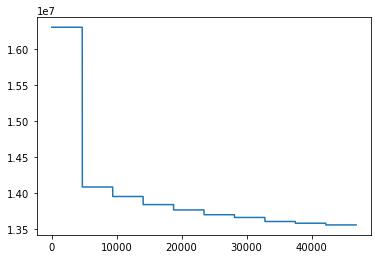

In [12]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

In [18]:
del all_losses

In [27]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [ ]:
#You need to see loss for validation set to tune the parameter. I didn't do that because linear regression is too simple

In [29]:
print(view_loss(model, test_set, test_label,criterion)/test_set.shape[0]*320)

tensor(2914.5986, device='cuda:0', grad_fn=<MulBackward0>)


In [24]:
predict_input = torch.load('predict_input.pt').to(device)
print(predict_input.shape)

torch.Size([320, 14])


In [25]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [26]:
out = predict(model)
print(out)

tensor([[ 887.6602],
        [ 884.4099],
        [ 887.6602],
        [ 887.6605],
        [ 879.9901],
        [ 933.1318],
        [ 887.6602],
        [ 933.1318],
        [ 886.8943],
        [ 887.6602],
        [ 873.5715],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 887.6602],
        [ 948.6939],
        [ 887.6602],
        [ 933.1318],
        [ 933.1318],
        [ 887.6602],
        [ 871.3582],
        [ 856.1127],
        [ 887.6602],
        [ 887.6602],
        [ 866.4194],
        [ 887.6602],
        [ 887.6602],
        [ 884.4099],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 948.6939],
        [ 933.1318],
        [ 879.7853],
        [ 887.6602],
        [ 887.8210],
        [ 872.5363],
        [ 948.6939],
        [ 948.6939],
        [ 886.8943],
        [ 874.9758],
        [ 883.6512],
        [ 948.6939],
        [ 948

In [47]:
linear_predict = pd.read_csv('test_public.csv')
linear_predict = linear_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
linear_predict= pd.concat([linear_predict, pd.DataFrame(predict_tensor)], axis=1)
linear_predict = linear_predict.rename(columns={0: 'TRAVEL_TIME'})
linear_predict.head()

,TRIP_ID,TRAVEL_TIME
0,T1,887.660217
1,T2,884.409851
2,T3,887.660217
3,T4,887.660461
4,T5,879.990051


In [48]:
linear_predict.to_csv('linear_predict.csv', index=False)

In [19]:
PATH = 'linear.pth'
torch.save(model.state_dict(),PATH)

In [12]:
model = MLP(14).to(device)
model_state = torch.load('linear.pth')
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
#Use sklearn for something like gradient boosting or random forest

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

In [ ]:
#TODO: build other models
#TODO: report loss on validation sets and tune parameters for each model
#TODO: run on test sets and report test loss
#TODO: predict travel time(test_features) and submit to kaggle